In [25]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import contextily as cx
# Importing distance from geopy to calculate geodesic distance
from geopy import distance
from shapely.geometry import Point
df = pd.read_csv('AB_US_2020.csv')
df_rats = pd.read_csv('NYC_Rat_Sightings_20240716.csv')

C:\Users\orian\AppData\Local\Temp\ipykernel_13436\1238531554.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AB_US_2020.csv')
C:\Users\orian\AppData\Local\Temp\ipykernel_13436\1238531554.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rats = pd.read_csv('NYC_Rat_Sightings_20240716.csv')


In [26]:
## Created a restricted dataframe for just NYC
df_ny = df[df['city'] == 'New York City']

In [27]:
# Lowercase the values
df_ny['neighbourhood_group'] = df_ny['neighbourhood_group'].str.lower()

C:\Users\orian\AppData\Local\Temp\ipykernel_13436\886290299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ny['neighbourhood_group'] = df_ny['neighbourhood_group'].str.lower()


Create 5 different dataframes to work as tables for the DB.

In [28]:
## From this we could easily extract no. of incidents/borough --> once in the database, extract no. of incidents/neighbhood
## However, we may want to refine it a bit more: set a given distance from an apartment and calculate how many rat incidents
## fall within that radius.
df_rats = df_rats[['Created Date', 'Incident Address', 'Borough', 'Latitude', 'Longitude']]

In [29]:
# Clean df_rats of null values in columns we want to address
df_rats.dropna(inplace = True, ignore_index = True)
df_rats.rename(columns={'Created Date':'date',
                        'Incident Address':'address',
                        'Borough':'neighbourhood_group',
                        'Latitude':'latitude',
                        'Longitude':'longitude'}, inplace=True)
# Lowercase the values
df_rats['neighbourhood_group'] = df_rats['neighbourhood_group'].str.lower()

In [30]:
df_apartments = df_ny[['id', 'name', 'host_id', 'room_type', 'price', 'number_of_reviews', 'availability_365']]
df_hosts = df_ny[['host_id', 'host_name']]
df_locations = df_ny[['id', 'name', 'latitude', 'longitude', 'neighbourhood_group']]
df_neighbourhoods = df_ny[['neighbourhood_group', 'neighbourhood']]
df_subway = pd.read_csv('MTA_Subway_Stations.csv')

In [31]:
# First define a function to calculate distance between an apartment and al rat sightings in its borough
def get_ratcount(row):
    borough = row['neighbourhood_group']
    apartment_location = (row['latitude'], row['longitude'])
    for _, rat in df_rats.iterrows():
        rat_count = 0
        # Calculate distance from a given apartment(row) to rat sightings if they are in its borough.
        # This is done to reduce the number of operations.
        if rat['neighbourhood_group'] == borough:
            rat_location = (rat['latitude'], rat['longitude'])
            rat_distance = distance.distance(rat_location, apartment_location).meters
            if rat_distance < 100:
                rat_count += 1
        return rat_count

The above function get_ratcount is NOT efficient. It would have to perform ~12.5 billion operations and take hours. Thus, we managed to get rat_counts per AirBnB from the code below:

In [32]:
# Using geopandas library 
import geopandas as gpd
from shapely.geometry import Point

# Convert to GeoDataFrames
gdf_apartments = gpd.GeoDataFrame(
    df_ny,
    geometry=gpd.points_from_xy(df_ny['longitude'], df_ny['latitude']),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

gdf_rats = gpd.GeoDataFrame(
    df_rats,
    geometry=gpd.points_from_xy(df_rats['longitude'], df_rats['latitude']),
    crs="EPSG:4326"
)

In [33]:
# Project to a coordinate system in meters
gdf_apartments = gdf_apartments.to_crs(epsg=2263)
gdf_rats = gdf_rats.to_crs(epsg=2263)

In [34]:
# Define the radius around apartment to count rats
gdf_apartments['buffer'] = gdf_apartments.geometry.buffer(100)

In [35]:
# Keep only borough and geometry for joining
gdf_apartments_buffer = gdf_apartments[['neighbourhood_group', 'buffer']].copy()
gdf_apartments_buffer = gdf_apartments_buffer.rename(columns={'buffer': 'geometry'})
gdf_apartments_buffer = gdf_apartments_buffer.set_geometry('geometry')

In [36]:
# Join rats to apartment buffers where borough matches
joined = gpd.sjoin(
    gdf_rats, 
    gdf_apartments_buffer, 
    how='inner', 
    predicate='within'
)

# Now count how many rats fell within each apartment's buffer
# sjoin gives index of apartments as 'index_right' in 'joined'
rat_counts = joined.groupby(joined.index_right).size()

In [37]:
# Default to 0, then fill in rat counts
gdf_apartments['rat_count'] = 0
gdf_apartments.loc[rat_counts.index, 'rat_count'] = rat_counts.values

In [38]:
# Create a new dataframe that contains only apartment id and rat count. Export it as csv to import to the DB
df_ratcounts = gdf_apartments[['id', 'rat_count']]
df_ratcounts.rename(columns={'id':'airbnb_id'}, inplace=True)
df_ratcounts.to_csv('rat_counts.csv', index=False)

C:\Users\orian\AppData\Local\Temp\ipykernel_13436\1890158298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratcounts.rename(columns={'id':'airbnb_id'}, inplace=True)


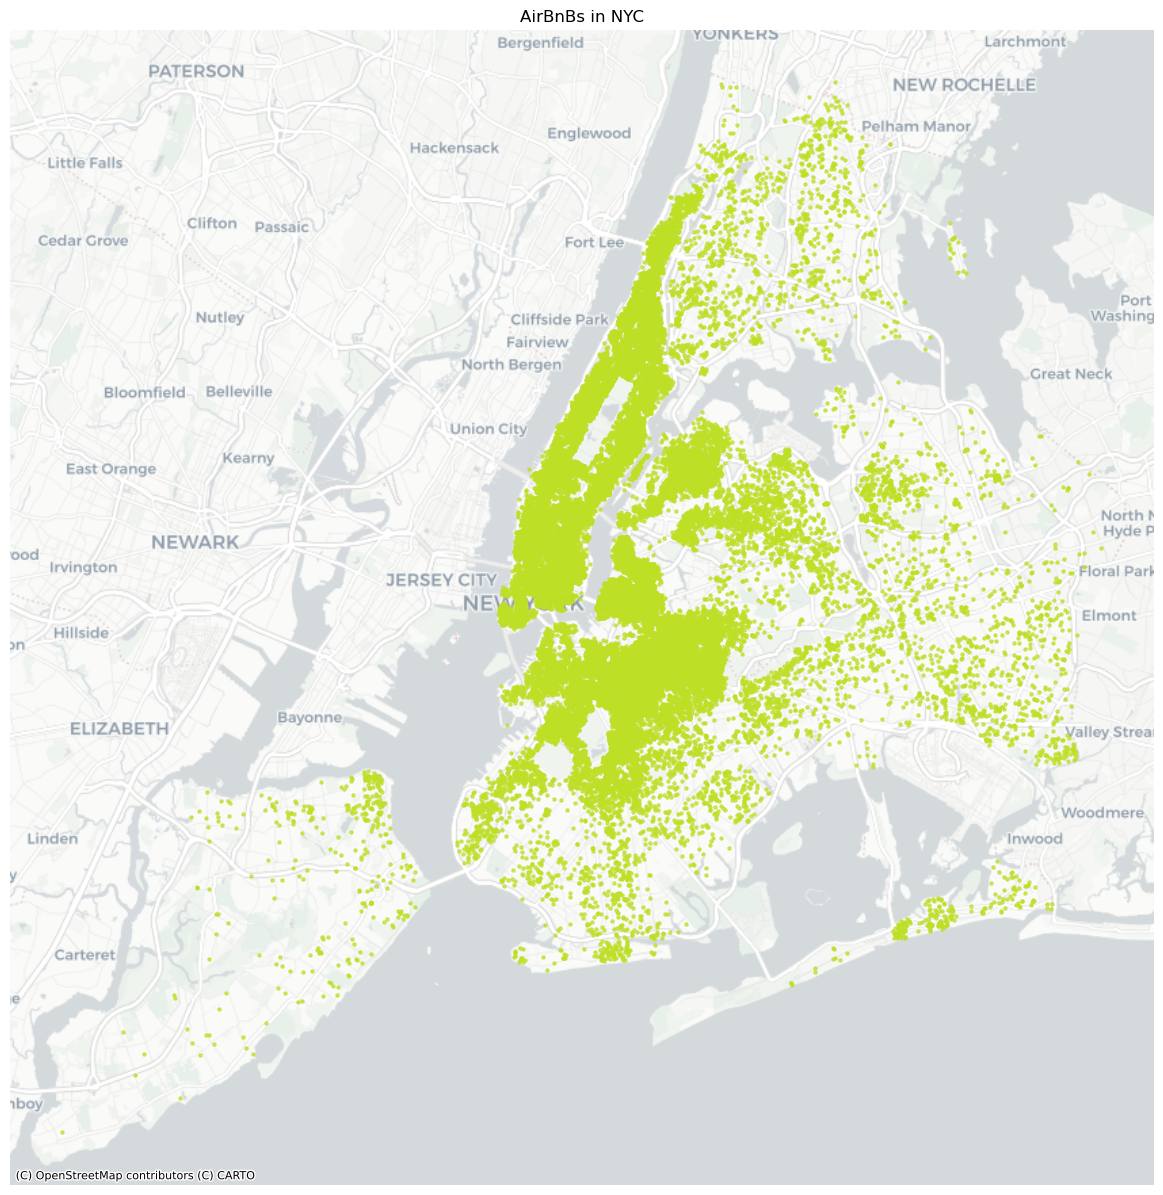

In [47]:
# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_ny,
    geometry=gpd.points_from_xy(df_ny["longitude"], df_ny["latitude"]),
    crs="EPSG:4326"  # WGS84: lat/lon
)

# Step 2: Reproject to Web Mercator (for contextily)
gdf = gdf.to_crs(epsg=3857)

# Step 3: Plot with contextily
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(
    ax=ax,
    color='#BDDF26',
    markersize=5,
    alpha=0.7,
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)  # clean basemap
ax.set_axis_off()
plt.title("AirBnBs in NYC")
plt.show()

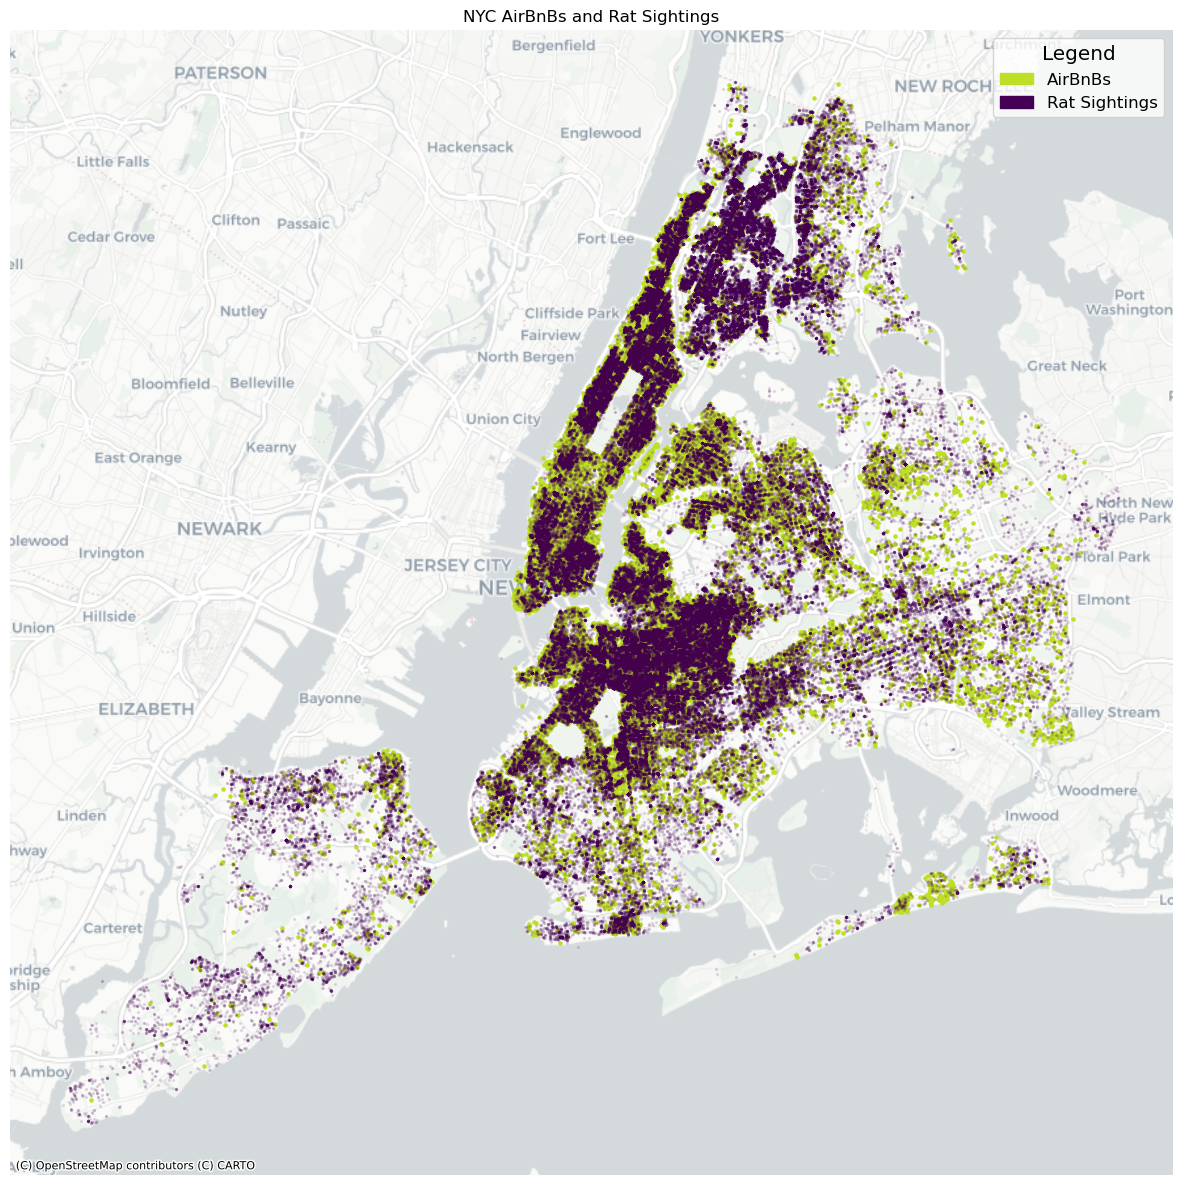

In [53]:
# Airbnb GeoDataFrame
gdf_ny = gpd.GeoDataFrame(
    df_ny,
    geometry=gpd.points_from_xy(df_ny["longitude"], df_ny["latitude"]),
    crs="EPSG:4326"
)

# Rat sightings GeoDataFrame
gdf_rats = gpd.GeoDataFrame(
    df_rats,
    geometry=gpd.points_from_xy(df_rats["longitude"], df_rats["latitude"]),
    crs="EPSG:4326"
)
# Reproject both to Web Mercator (EPSG:3857)
gdf_ny = gdf_ny.to_crs(epsg=3857)
gdf_rats = gdf_rats.to_crs(epsg=3857)

# Plot both on the same map
fig, ax = plt.subplots(figsize=(15, 15))

# Plot AirBnBs in blue
gdf_ny.plot(
    ax=ax,
    color='#BDDF26',
    markersize=5,
    alpha=1,
    label='AirBnBs'
)

# Plot rat sightings in red
gdf_rats.plot(
    ax=ax,
    color='#440154FF',
    markersize=2,
    alpha=0.1,
    label='Rat Sightings'
)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Manually create legend
legend_elements = [
    mpatches.Patch(color='#BDDF26', label='AirBnBs'),
    mpatches.Patch(color='#440154FF', label='Rat Sightings')
]

# Add legend with larger font and custom location
ax.legend(
    handles=legend_elements,
    loc='upper right',      # or 'lower left', etc.
    fontsize='large',       # can also use a number like 14
    title='Legend',
    title_fontsize='x-large'
)

# Tidy up the plot
ax.set_axis_off()
ax.set_title("NYC AirBnBs and Rat Sightings")

plt.show()


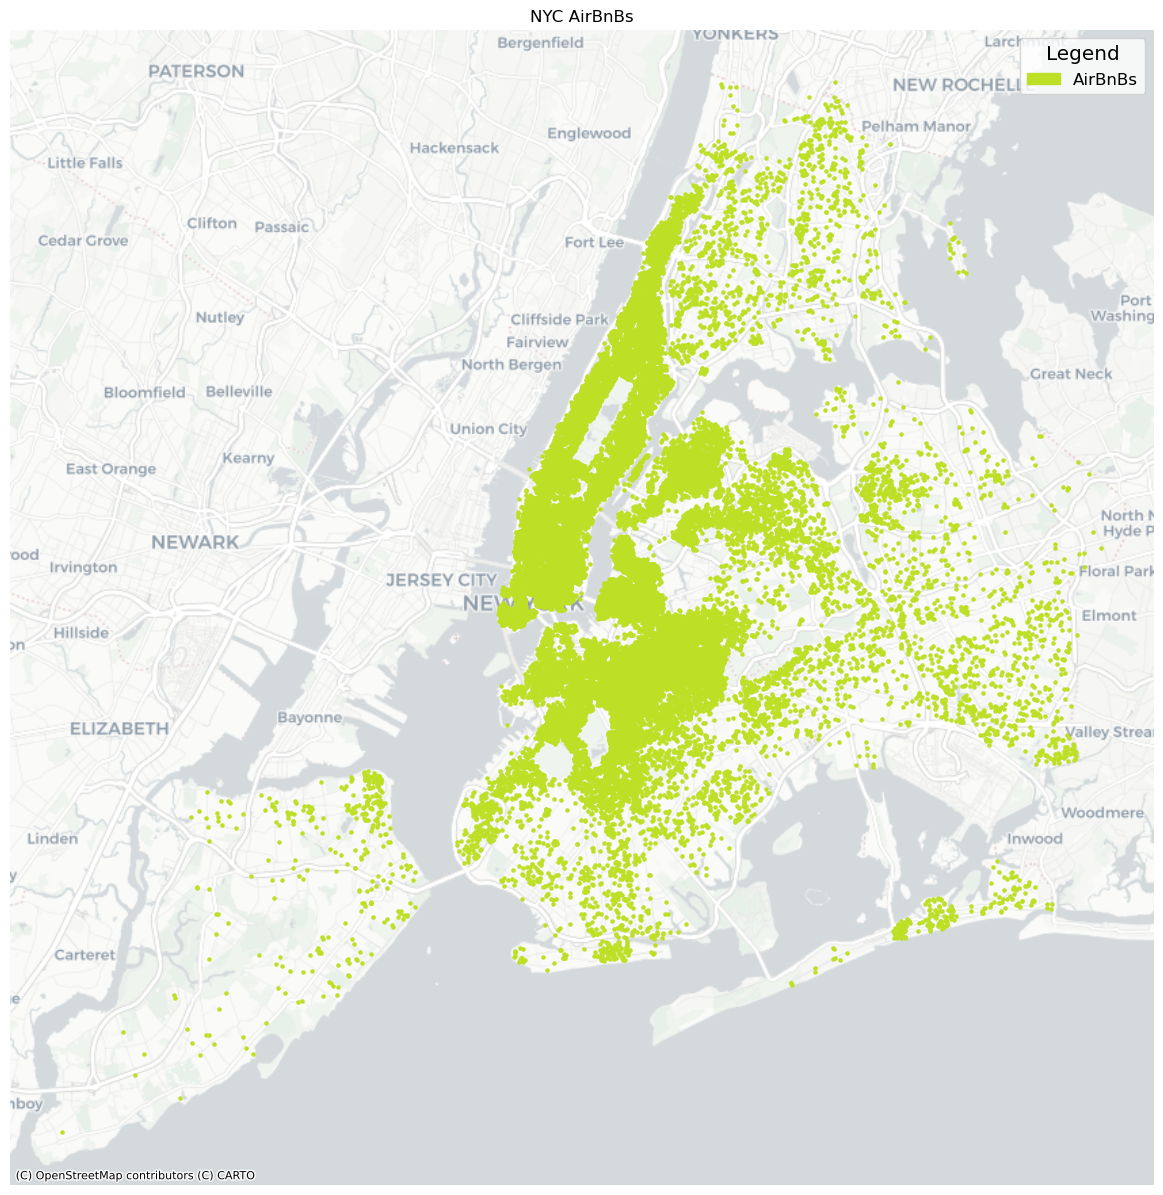

In [54]:
# Airbnb GeoDataFrame
gdf_ny = gpd.GeoDataFrame(
    df_ny,
    geometry=gpd.points_from_xy(df_ny["longitude"], df_ny["latitude"]),
    crs="EPSG:4326"
)

# Rat sightings GeoDataFrame
gdf_rats = gpd.GeoDataFrame(
    df_rats,
    geometry=gpd.points_from_xy(df_rats["longitude"], df_rats["latitude"]),
    crs="EPSG:4326"
)
# Reproject both to Web Mercator (EPSG:3857)
gdf_ny = gdf_ny.to_crs(epsg=3857)
gdf_rats = gdf_rats.to_crs(epsg=3857)

# Plot both on the same map
fig, ax = plt.subplots(figsize=(15, 15))

# Plot AirBnBs in blue
gdf_ny.plot(
    ax=ax,
    color='#BDDF26',
    markersize=5,
    alpha=1,
    label='AirBnBs'
)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Manually create legend
legend_elements = [
    mpatches.Patch(color='#BDDF26', label='AirBnBs')
]

# Add legend with larger font and custom location
ax.legend(
    handles=legend_elements,
    loc='upper right',      # or 'lower left', etc.
    fontsize='large',       # can also use a number like 14
    title='Legend',
    title_fontsize='x-large'
)

# Tidy up the plot
ax.set_axis_off()
ax.set_title("NYC AirBnBs")

plt.show()


C:\Users\orian\AppData\Local\Temp\ipykernel_13436\1990230751.py:54: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize='medium')


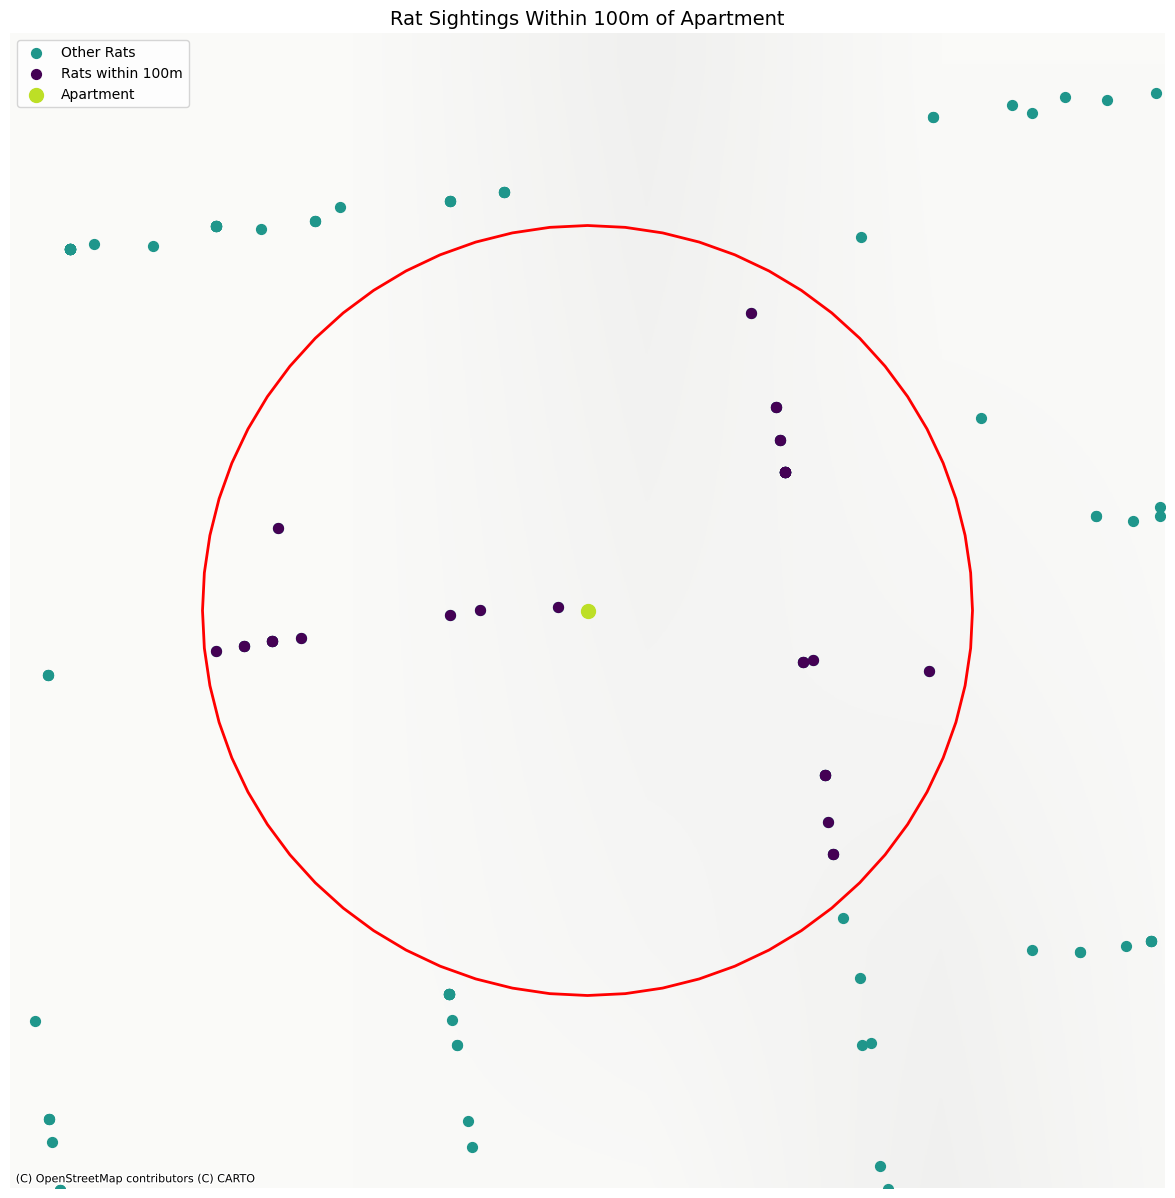

In [ ]:
# Pick a specific apartment in Staten Island
target_apartment = df_ny[df_ny['neighbourhood_group'] == 'brooklyn'].iloc[0]

#Convert apartment + rats to GeoDataFrames
# Apartment GeoDataFrame
apartment_geom = Point(target_apartment['longitude'], target_apartment['latitude'])
gdf_apartment = gpd.GeoDataFrame([target_apartment], geometry=[apartment_geom], crs="EPSG:4326")

# Rats GeoDataFrame
gdf_rats = gpd.GeoDataFrame(
    df_rats,
    geometry=gpd.points_from_xy(df_rats["longitude"], df_rats["latitude"]),
    crs="EPSG:4326"
)

# Reproject to EPSG:3857 (meters)
gdf_apartment = gdf_apartment.to_crs(epsg=3857)
gdf_rats = gdf_rats.to_crs(epsg=3857)

# Create a 100-meter buffer around the apartment
buffer = gdf_apartment.geometry.buffer(100).iloc[0]

# Select rat sightings within the buffer
rats_within = gdf_rats[gdf_rats.geometry.within(buffer)]

# Plot zoomed map showing apartment, buffer, and rats
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(figsize=(15, 15))

# Plot all rats faintly in gray
gdf_rats.plot(ax=ax, color='#1F968BFF', markersize=50, label='Other Rats')

# Plot rats within 100m
rats_within.plot(ax=ax, color='#440154FF', markersize=5, label='Rats within 100m')

# Plot buffer around apartment
gpd.GeoSeries(buffer).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='100m Radius')

# Plot the apartment
gdf_apartment.plot(ax=ax, color='#BDDF26', markersize=0, label='Apartment')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Zoom in to the buffer area
ax.set_xlim(buffer.bounds[0] - 50, buffer.bounds[2] + 50)
ax.set_ylim(buffer.bounds[1] - 50, buffer.bounds[3] + 50)

# Styling
ax.set_title("Rat Sightings Within 100m of Apartment", fontsize=14)
ax.set_axis_off()
ax.legend(fontsize='medium')

plt.show()


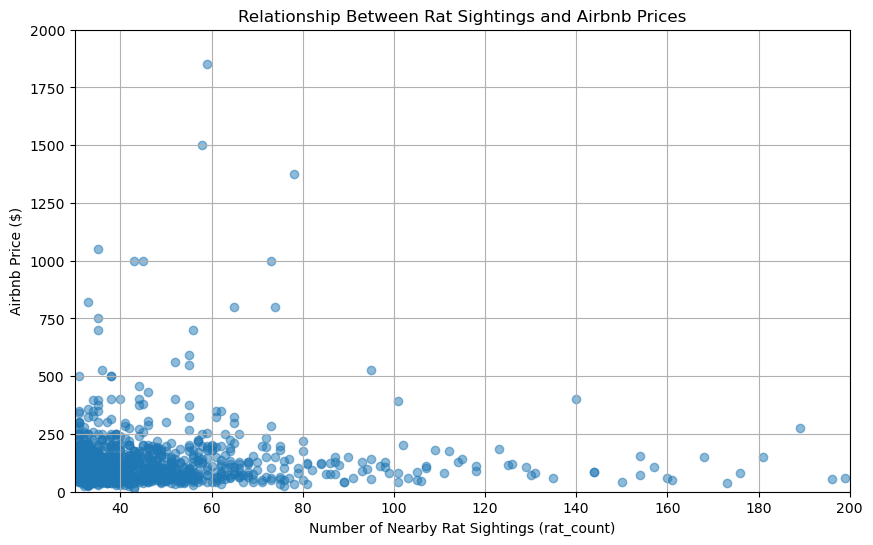

In [61]:
df_rats_price = pd.read_csv('rats_price.csv')
plt.figure(figsize=(10, 6))

# Basic scatter plot
plt.scatter(df_rats_price["rat_count"], df_rats_price["price"], alpha=0.5)

# Labels and title
plt.xlabel("Number of Nearby Rat Sightings (rat_count)")
plt.ylabel("Airbnb Price ($)")
plt.title("Relationship Between Rat Sightings and Airbnb Prices")
plt.xlim(30, 200)  # Limit to max 50 rats
plt.ylim(0, 2000)  # Limit to prices under $1000

plt.grid(True)
plt.show()
